In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from pandas import get_dummies

In [2]:
df = pd.read_csv('../Resources/vg_sales.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


**TOP VALUES**

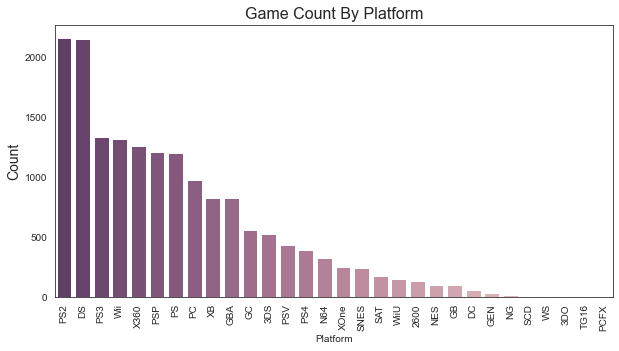

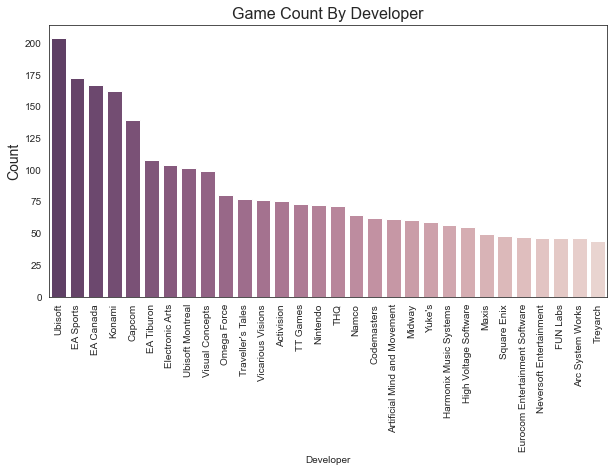

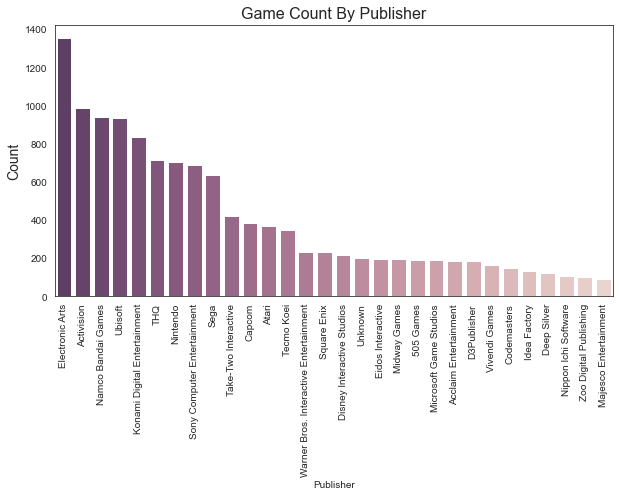

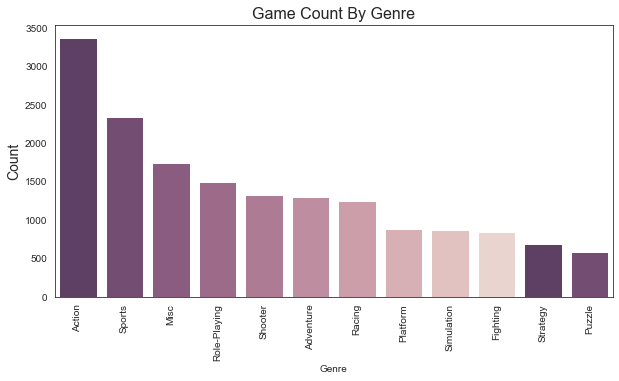

In [3]:
cols = ['Platform', 'Developer', 'Publisher', 'Genre']

for col in cols:
    chart = df[['Name', col]].groupby([col]).count().sort_values('Name', ascending=False).reset_index()
    sns.set_style("white")
    plt.figure(figsize=(10, 5))
    plt.xticks(rotation=90)
    sns.barplot(x=col, y='Name', data=chart[:30], palette=sns.cubehelix_palette((10 if col == 'Genre' else 30), dark=0.3, light=.85, reverse=True)).set_title(('Game Count By '+col), fontsize=16)
    plt.ylabel('Count', fontsize=14)

**SALES vs CRITIC SCORES**

In [4]:
# Defining score groups for additional column

def score_group(score):
    if score >= 90:
        return '90-100'
    elif score >= 80:
        return '80-89'
    elif score >= 70:
        return '70-79'
    elif score >= 60:
        return '60-69'
    elif score >= 50:
        return '50-59'
    else:
        return '0-49'

In [5]:
# Adding score group column to DataFrame

df_score = df.dropna(subset=['Critic_Score']).reset_index(drop=True)
df_score['Score_Group'] = df_score['Critic_Score'].apply(lambda x: score_group(x))
df_score.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Score_Group
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E,70-79
1,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E,80-89
2,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E,80-89
3,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,E,80-89
4,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E,50-59


[(0.0, 17.5)]

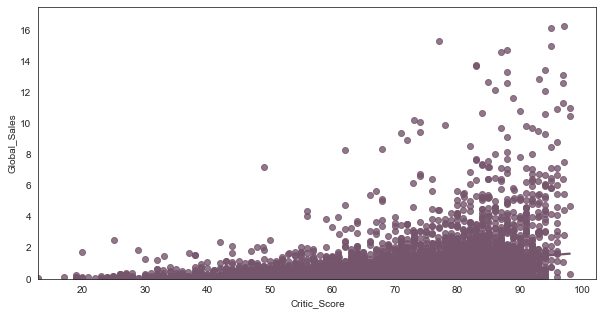

In [6]:
# Plotting critic score versus global sales to see what kind of correlation there may be

fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.regplot(x="Critic_Score", y="Global_Sales", data=df_score, ci=None, color="#75556c", x_jitter=.02).set(ylim=(0, 17.5))

[(0.0, 4.0), (50.0, 95.0)]

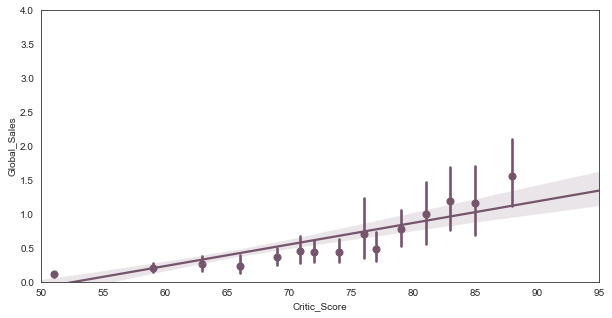

In [7]:
# Replotting critic score versus global sales to get a better visual for the correlation

fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.regplot(x="Critic_Score", y="Global_Sales", data=df_score.loc[df_score.Year_of_Release >= 2014], truncate=True, x_bins=15, color="#75556c").set(ylim=(0, 4), xlim=(50, 95))

**PREPROCESSING**

In [8]:
vg_df = pd.read_csv('../Resources/vg_sales.csv')

In [9]:
vg_df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
vg_df['Hit'] = vg_df['Global_Sales']
vg_df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Hit
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E,82.53
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN,31.37


In [11]:
def hit(sales):

    if sales >= 10:
        return "Yes"
    else:
        return "No"

vg_df['Hit'] = vg_df['Hit'].apply(lambda x: hit(x))

vg_df.head(1000)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Hit
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E,Yes
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN,Yes
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E,Yes
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E,Yes
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Golden Sun,GBA,2001.0,Role-Playing,Nintendo,0.93,0.38,0.40,0.06,1.76,91.0,29.0,9.3,198.0,Camelot Software Planning,E,No
996,Sonic the Hedgehog 3,GEN,1994.0,Platform,Sega,1.02,0.47,0.20,0.07,1.76,NaN,NaN,NaN,NaN,NaN,NaN,No
997,Kid Icarus,NES,1986.0,Platform,Nintendo,0.53,0.12,1.09,0.02,1.76,NaN,NaN,NaN,NaN,NaN,NaN,No
998,Def Jam: Fight for NY,PS2,2004.0,Fighting,Electronic Arts,0.86,0.67,0.00,0.22,1.76,83.0,46.0,8.9,73.0,Aki Corp.,M,No


In [12]:
vg2_d_full = pd.read_csv('../Resources/vg_sales.csv')

In [13]:
vg2_df = vg2_d_full.sample(frac=.50)

In [14]:
vg2_df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
6020,Nicktoons: Battle for Volcano Island,GC,NaN,Action,Unknown,0.22,0.06,0.00,0.01,0.29,NaN,NaN,7,4.0,Blue Tongue Entertainment,E
2606,FIFA Soccer 2004,XB,2003.0,Sports,Electronic Arts,0.24,0.49,0.00,0.05,0.79,82.0,20.0,8.2,23.0,EA Canada,E
285,Super Mario World 2: Yoshi's Island,SNES,1995.0,Platform,Nintendo,1.65,0.61,1.76,0.09,4.12,NaN,NaN,NaN,NaN,NaN,NaN
15613,Niko Puchi Girls Runway,3DS,2015.0,Misc,Happinet,0.00,0.00,0.02,0.00,0.02,NaN,NaN,NaN,NaN,NaN,NaN
15741,Aqua Panic!,DS,2009.0,Puzzle,Neko Entertainment,0.01,0.01,0.00,0.00,0.02,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
vg2_df['Hit'] = vg2_df['Global_Sales']
vg2_df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Hit
6020,Nicktoons: Battle for Volcano Island,GC,NaN,Action,Unknown,0.22,0.06,0.00,0.01,0.29,NaN,NaN,7,4.0,Blue Tongue Entertainment,E,0.29
2606,FIFA Soccer 2004,XB,2003.0,Sports,Electronic Arts,0.24,0.49,0.00,0.05,0.79,82.0,20.0,8.2,23.0,EA Canada,E,0.79
285,Super Mario World 2: Yoshi's Island,SNES,1995.0,Platform,Nintendo,1.65,0.61,1.76,0.09,4.12,NaN,NaN,NaN,NaN,NaN,NaN,4.12
15613,Niko Puchi Girls Runway,3DS,2015.0,Misc,Happinet,0.00,0.00,0.02,0.00,0.02,NaN,NaN,NaN,NaN,NaN,NaN,0.02
15741,Aqua Panic!,DS,2009.0,Puzzle,Neko Entertainment,0.01,0.01,0.00,0.00,0.02,NaN,NaN,NaN,NaN,NaN,NaN,0.02


In [16]:
def hit(sales):

    if sales >= 10:
        return "Yes"
    else:
        return "No"

vg2_df['Hit'] = vg2_df['Hit'].apply(lambda x: hit(x))

vg2_df.head(1000)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Hit
6020,Nicktoons: Battle for Volcano Island,GC,NaN,Action,Unknown,0.22,0.06,0.00,0.01,0.29,NaN,NaN,7,4.0,Blue Tongue Entertainment,E,No
2606,FIFA Soccer 2004,XB,2003.0,Sports,Electronic Arts,0.24,0.49,0.00,0.05,0.79,82.0,20.0,8.2,23.0,EA Canada,E,No
285,Super Mario World 2: Yoshi's Island,SNES,1995.0,Platform,Nintendo,1.65,0.61,1.76,0.09,4.12,NaN,NaN,NaN,NaN,NaN,NaN,No
15613,Niko Puchi Girls Runway,3DS,2015.0,Misc,Happinet,0.00,0.00,0.02,0.00,0.02,NaN,NaN,NaN,NaN,NaN,NaN,No
15741,Aqua Panic!,DS,2009.0,Puzzle,Neko Entertainment,0.01,0.01,0.00,0.00,0.02,NaN,NaN,NaN,NaN,NaN,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,Assassin's Creed Syndicate,XOne,2015.0,Action,Ubisoft,0.62,0.56,0.00,0.11,1.30,78.0,22.0,6.1,402.0,Ubisoft Quebec,M,No
2003,WipEout Pure,PSP,2005.0,Racing,Sony Computer Entertainment,0.47,0.34,0.00,0.23,1.03,88.0,56.0,7.9,102.0,Studio Liverpool,E,No
3600,ESPN NFL Football,PS2,2003.0,Sports,Sega,0.27,0.21,0.00,0.07,0.56,91.0,20.0,8.5,25.0,Visual Concepts,E,No
7640,Dying Light,PC,2015.0,Action,Warner Bros. Interactive Entertainment,0.12,0.06,0.00,0.02,0.20,75.0,40.0,7.9,1295.0,Techland,M,No


In [17]:
vg_drop = vg_df.dropna()
vg2_drop = vg2_df.dropna()

In [18]:
train_df = vg_drop[['Platform', 'Genre', 'Publisher', 'Year_of_Release', 'Critic_Score', 'Hit']]
test_df = vg2_drop[['Platform', 'Genre', 'Publisher', 'Year_of_Release', 'Critic_Score', 'Hit']]

In [19]:
train_df.shape

(6825, 6)

In [20]:
test_df.shape

(3417, 6)

In [21]:
train_df.head()

,Platform,Genre,Publisher,Year_of_Release,Critic_Score,Hit
0,Wii,Sports,Nintendo,2006.0,76.0,Yes
2,Wii,Racing,Nintendo,2008.0,82.0,Yes
3,Wii,Sports,Nintendo,2009.0,80.0,Yes
6,DS,Platform,Nintendo,2006.0,89.0,Yes
7,Wii,Misc,Nintendo,2006.0,58.0,Yes


In [22]:
train_df = pd.get_dummies(data=train_df, columns=['Platform', 'Genre', 'Publisher', 'Critic_Score', 'Hit'])

In [23]:
train_df.head()

,Year_of_Release,Platform_3DS,Platform_DC,Platform_DS,Platform_GBA,Platform_GC,Platform_PC,Platform_PS,Platform_PS2,Platform_PS3,...,Critic_Score_91.0,Critic_Score_92.0,Critic_Score_93.0,Critic_Score_94.0,Critic_Score_95.0,Critic_Score_96.0,Critic_Score_97.0,Critic_Score_98.0,Hit_No,Hit_Yes
0,2006.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2008.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2009.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,2006.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,2006.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [24]:
X_train = train_df.drop('Hit_Yes', axis=1)
X_train = X_train.drop('Hit_No',axis=1)
y_train = train_df['Hit_Yes']

In [25]:
test_df.head()

,Platform,Genre,Publisher,Year_of_Release,Critic_Score,Hit
2606,XB,Sports,Electronic Arts,2003.0,82.0,No
13393,PC,Simulation,Electronic Arts,2000.0,92.0,No
7975,PS3,Role-Playing,Nippon Ichi Software,2013.0,65.0,No
13048,PC,Fighting,Warner Bros. Interactive Entertainment,2015.0,76.0,No
6307,X360,Racing,Codemasters,2012.0,64.0,No


In [26]:
test_df = pd.get_dummies(data=test_df, columns=['Platform', 'Genre', 'Publisher', 'Critic_Score', 'Hit'])

In [27]:
X_test = test_df.drop('Hit_Yes', axis=1)
X_test = X_test.drop('Hit_No',axis=1)
y_test = test_df['Hit_Yes']

**LOGISTIC REGRESSION MODEL AND RANDOM FOREST CLASSIFIER MODEL**

In [28]:
# Train the Logistic Regression model on the unscaled data and print the model score

from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

In [29]:
classifier.fit(X_train, y_train)
print(f"Training Score: {classifier.score(X_train, y_train)}")
print(f"Testing Score: {classifier.score(X_test, y_test)}")

Training Score: 0.9941391941391942


C:\Users\cpres\anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ValueError: X has 318 features per sample; expecting 373

In [30]:
# Train a Random Forest Classifier model and print the model score

from sklearn.ensemble import RandomForestClassifier
rfclassifier = RandomForestClassifier(random_state=1, n_estimators=500).fit(X_train, y_train)

In [31]:
print(f'Training Score: {rfclassifier.score(X_train, y_train)}')
print(f'Testing Score: {rfclassifier.score(X_test, y_test)}')

Training Score: 1.0


ValueError: Number of features of the model must match the input. Model n_features is 373 and input n_features is 318 